# Tutorial 2 — Wrap an existing solver: `odeint` as a Process

In this tutorial we build an **ODE Process** that *wraps an existing numerical solver*:
`scipy.integrate.odeint`.

The point is not just “solve an ODE”, but to learn a reusable pattern:

**How to wrap an external method by exposing its API as a Process interface + config.**

We will:
1. Import and verify `odeint`
2. Define an `ODEIntProcess` that exposes the solver API (dt, params, method args)
3. Provide an ODE RHS function and configure the process
4. Run it in a `Composite`
5. Add an emitter to record trajectories

In [12]:
import numpy as np
import sys, inspect
import matplotlib.pyplot as plt

from process_bigraph import allocate_core
from process_bigraph.composite import Process, Composite
from process_bigraph.emitter import emitter_from_wires

core = allocate_core(top=dict(inspect.getmembers(sys.modules["__main__"])))
print("✅ Core ready")


✅ Core ready


In [13]:
try:
    from scipy.integrate import odeint
    print("✅ scipy.integrate.odeint imported")
except Exception as e:
    raise ImportError(
        "This tutorial requires SciPy. Install with: pip install scipy\n"
        f"Import error: {e}"
    )

✅ scipy.integrate.odeint imported


## Wrapping pattern

We will write a Process called `ODEIntProcess` that:
- declares **ports**: inputs/outputs
- declares a **config API** that mirrors the external library call
- converts hierarchical state into the solver’s expected arrays
- calls `odeint(...)`
- returns the updated state (and optionally a small trajectory)

Key design choices:
- Keep the **Process interface stable** (inputs/outputs don’t change)
- Put solver details behind **config** (dt, tolerances, extra args)
- Use explicit **state-to-array mapping** (`state_keys`) so we can round-trip safely


In [14]:
class ODEIntProcess(Process):
    """
    Wraps scipy.integrate.odeint as a process-bigraph Process.
    """

    config_schema = {
        "state_keys": "list[string]",
        "dt": {"_type": "float", "_default": 0.1},

        # These are arbitrary python objects (dicts, callables, etc.)
        # Use 'node' to avoid schema trying to default/validate internal structure.
        "params": {"_type": "node", "_default": {}},
        "rhs": "node",
        "odeint_kwargs": {"_type": "node", "_default": {}},
    }

    def initialize(self, config=None):
        # At this point, config has already been filled using config_schema defaults.
        # We can still enforce required fields here.
        if "state_keys" not in self.config:
            raise ValueError("ODEIntProcess requires config['state_keys'] (list of variable names)")
        if "rhs" not in self.config or not callable(self.config["rhs"]):
            raise ValueError("ODEIntProcess requires config['rhs'] as a callable")
        return self.config

    def inputs(self):
        return {"y": "map[float]", "t": "float"}

    def outputs(self):
        return {"y": "map[float]", "t": "float"}

    def _dict_to_vec(self, y_dict):
        keys = self.config["state_keys"]
        return np.array([float(y_dict[k]) for k in keys], dtype=float)

    def _vec_to_dict(self, y_vec):
        keys = self.config["state_keys"]
        return {k: float(y_vec[i]) for i, k in enumerate(keys)}

    def update(self, state, interval):
        y_dict = state["y"]
        t0 = float(state["t"])
        t1 = t0 + float(interval)

        dt = float(self.config["dt"])
        params = self.config.get("params", {})
        rhs = self.config["rhs"]
        odeint_kwargs = dict(self.config.get("odeint_kwargs", {}))

        # time grid for odeint over this interval
        n_steps = max(2, int(np.ceil((t1 - t0) / dt)) + 1)
        ts = np.linspace(t0, t1, n_steps)

        y0 = self._dict_to_vec(y_dict)

        def f(y_vec, t, params):
            dy = rhs(y_vec, t, params)
            return np.asarray(dy, dtype=float)

        traj = odeint(f, y0, ts, args=(params,), **odeint_kwargs)
        y_end = traj[-1, :]

        return {"y": self._vec_to_dict(y_end), "t": float(t1)}


print("✅ ODEIntProcess defined")

# Register the class so Composite can resolve "local:ODEIntProcess"
core.register_link("ODEIntProcess", ODEIntProcess)

# quick sanity check: this should now succeed
print("✅ registered:", core.link_registry.get("ODEIntProcess"))


✅ ODEIntProcess defined
✅ registered: <class '__main__.ODEIntProcess'>


## Define an ODE right-hand side

We now define a concrete ODE model and pass it into `ODEIntProcess`
*via configuration*.

This example uses **logistic growth**:

$$
\frac{dX}{dt} = r X \left(1 - \frac{X}{K}\right)
$$

Key point:
- The solver (`odeint`) is hidden inside the Process
- The *model* is injected via a small, well-defined API (`rhs`, `params`)


In [15]:
def rhs_logistic(y_vec, t, params):
    """
    Logistic growth RHS.

    y_vec : numpy array, ordered according to state_keys
    t     : time (unused here, but included for generality)
    params: dict with keys 'r' and 'K'
    """
    X = float(y_vec[0])
    r = float(params["r"])
    K = float(params["K"])
    return np.array([r * X * (1.0 - X / K)], dtype=float)


# Instantiate the process directly (no Composite yet)
ode = ODEIntProcess(
    config={
        "state_keys": ["X"],
        "rhs": rhs_logistic,
        "params": {"r": 1.0, "K": 10.0},
        "dt": 0.05,
    },
    core=core,
)

# Run a single update over a finite interval
out = ode.update(
    state={"y": {"X": 0.5}, "t": 0.0},
    interval=2.0,
)

print("Single update result:", out)


Single update result: {'y': {'X': 2.800045627983243}, 't': 2.0}


## Run the ODE solver inside a Composite (with an emitter)

Now we embed `ODEIntProcess` in a `Composite` so it can be scheduled and run like
any other process-bigraph component.

We also add an **emitter** to record a time series of:
- `global_time` (the composite clock)
- `t` (the ODE's internal model time)
- `X` (the state variable)


In [16]:
sim = Composite(
    {
        "state": {
            # shared model state
            "t": 0.0,
            "y": {"X": 0.5},

            # our ODE process node
            "ode": {
                "_type": "process",
                "address": "local:ODEIntProcess",
                "config": {
                    "state_keys": ["X"],
                    "rhs": rhs_logistic,
                    "params": {"r": 1.0, "K": 10.0},
                    "dt": 0.05,
                    "odeint_kwargs": {"rtol": 1e-8, "atol": 1e-10},
                },
                "interval": 0.2,  # integrate this much each process update
                "inputs": {"t": ["t"], "y": ["y"]},
                "outputs": {"t": ["t"], "y": ["y"]},
            },

            # record a time series
            "emitter": emitter_from_wires({
                "time": ["global_time"],
                "t": ["t"],
                "X": ["y", "X"],
            }),
        }
    },
    core=core,
)

# Run the composite for 5.0 units of composite time
sim.run(5.0)

records = sim.state["emitter"]["instance"].query()
print("n records:", len(records))
print("first:", records[0])
print("last:", records[-1])


n records: 25
first: {'time': 0.0, 't': 0.0, 'X': 0.5}
last: {'time': 4.800000000000002, 't': 3355443.0, 'X': 872.4570899447776}


## Plot the trajectory

We can now plot `X` versus `t` using the values recorded by the emitter.


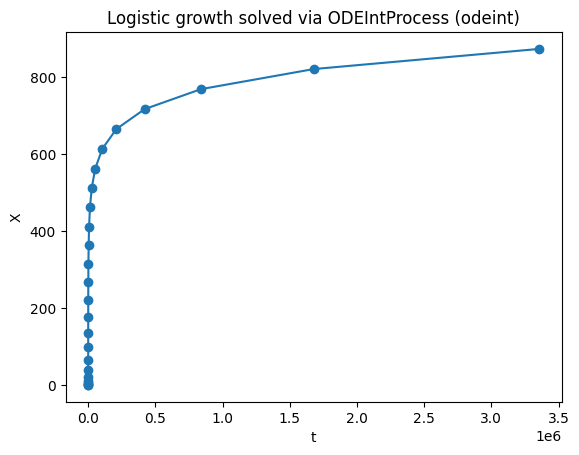

In [17]:
ts = [row["t"] for row in records]
xs = [row["X"] for row in records]

plt.figure()
plt.plot(ts, xs, marker="o")
plt.xlabel("t")
plt.ylabel("X")
plt.title("Logistic growth solved via ODEIntProcess (odeint)")
plt.show()
